In [2]:
import requests
import os
from datetime import datetime
from pathlib import Path
import pyarrow
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.ops import unary_union

root_dir = "~/Desktop/Desktop/epidemiology_PhD/00_repos/"
# root_dir = "/Volumes/squirrel-utopia 1/los_angeles_2025_fire_disasters_exp/"

In [3]:
# Ready to read data
data_dir = root_dir + "los_angeles_2025_fire_disasters_exp/data"
wf_path =  root_dir + "los_angeles_2025_fire_disasters_exp/data/calfire_boundaries/data_2025_01_14.geojson"

fires = gpd.read_file(wf_path)
fires = fires[fires['poly_DateCurrent'] > '2025-01-06']

<Axes: >

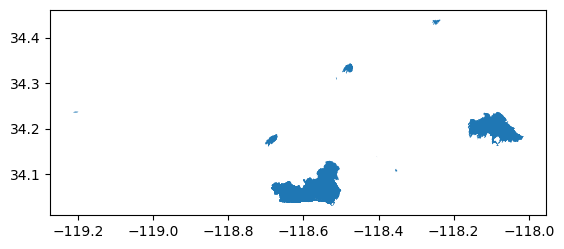

In [4]:
# plot fires
fires.plot()

In [5]:
# Create an empty list to store the groups of intersecting geometries
groups = []

# Iterate over each polygon
for i, poly in fires.iterrows():
    # Check if the polygon intersects with any existing group
    found_group = False
    for group in groups:
        if any(poly.geometry.intersects(g) for g in group):
            group.append(poly.geometry)
            found_group = True
            break
    # If no intersecting group is found, create a new group
    if not found_group:
        groups.append([poly.geometry])

# Perform unary union on each group to merge intersecting geometries
merged_geometries = [unary_union(group) for group in groups]

In [6]:
print(merged_geometries)
# make the list into a geodataframe
# this isn't working but i had to quit
merged_gdf = gpd.GeoDataFrame(geometry=merged_geometries, crs=fires.crs)

[<MULTIPOLYGON (((-118.561 34.043, -118.561 34.043, -118.561 34.042, -118.561...>, <POLYGON ((-118.256 34.434, -118.255 34.434, -118.255 34.434, -118.255 34.43...>, <MULTIPOLYGON (((-118.354 34.105, -118.354 34.105, -118.354 34.105, -118.354...>, <MULTIPOLYGON (((-118.157 34.181, -118.157 34.181, -118.157 34.181, -118.157...>, <POLYGON ((-118.47 34.33, -118.47 34.33, -118.47 34.33, -118.47 34.33, -118....>, <MULTIPOLYGON (((-118.684 34.171, -118.684 34.171, -118.684 34.171, -118.683...>, <MULTIPOLYGON (((-118.512 34.308, -118.512 34.308, -118.512 34.308, -118.512...>, <MULTIPOLYGON (((-119.213 34.236, -119.213 34.236, -119.213 34.236, -119.213...>]


In [7]:
print(merged_gdf)

                                            geometry
0  MULTIPOLYGON (((-118.56123 34.04269, -118.5612...
1  POLYGON ((-118.25563 34.43419, -118.25547 34.4...
2  MULTIPOLYGON (((-118.35381 34.10469, -118.3537...
3  MULTIPOLYGON (((-118.15682 34.18148, -118.1568...
4  POLYGON ((-118.46963 34.33044, -118.46957 34.3...
5  MULTIPOLYGON (((-118.6837 34.17072, -118.68363...
6  MULTIPOLYGON (((-118.51183 34.30772, -118.5119...
7  MULTIPOLYGON (((-119.21283 34.23611, -119.2128...


In [8]:
# write merged_geometries as parquet 
# separate fires 
sep_fires_path = os.path.join(data_dir, 'sep_fires.parquet')
merged_gdf.to_parquet(sep_fires_path)
